## Task 3/5: Approximating nonlinear vector fields
Download the datasets nonlinear_vectorfield_data_x0.txt and nonlinear_vectorfield_data_x1.txt from Moodle. They each contain N = 2000 rows and two columns, for N data points $x_{0}$ and $x_{1}$ in two dimensions. The first dataset contains the initial points over the domain $[−4.5, 4.5]^{2}$ , while the second dataset contains the same points advanced with an unknown (to you) evolution operator $ψ : T × R^2 → R^2$ , such that

$x_{1}^{(k)} = ψ(∆t, x_{0}^{(k)}) ,    k = 1, . . . , N$

with a small ∆t = 0.01, i.e., smaller than in the task on linear vector fields

Loading Imports and Opening downloaded datasets ....

In [70]:
import numpy as np
from rbf_utils import *

f1 = open('nonlinear_vectorfield_data_x0.txt')
f2 = open('nonlinear_vectorfield_data_x1.txt')

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [56]:
x0_array = []
for line in f1:
    words = line.split(" ")
    x0_array.append(words)

x1_array = []
for line in f2:
    words = line.split(" ")
    x1_array.append(words)

X0 = np.array(x0_array, dtype=float)
X1 = np.array(x1_array, dtype=float)

### Estimating vector field describing the field with a linear operator

Here we try to estimate the vector field describing $\psi$ with a linear operator $A \in R^{2X2}$ such that

$\frac{d}{ds}\psi(s,x(t)) \approx f_{linear}(x(t)) = \nu^{(k)} = Ax(t)$

where 

$\nu^{(k)} = \frac{x_{1}^{(k)} - x_{0}^{(k)}}{\Delta t} $ 

Solving for A using least squares ...

$A = (X^{T}X)^{-1}X^{T}F_{linear}$

In [57]:
dt = 0.01
F_linear = (X1 - X0)/dt

global A
#A = np.linalg.pinv(X0.T@X0)@X0.T@F_linear
A = np.linalg.lstsq(X0, F_linear, rcond=None)[0]

Once we obtain A, we start at each individual initial point $x_{0}$ and solve the above differential equation up to a small time $\Delta t$, to obtain an approximate end point $\hat{x_{1}}$ as close as possible to the known end point $x_{1}$. 
We then compute the mean squared error between all the approximated and known end points for your chosen $\Delta t$ (here 0.01)

In [58]:
from scipy.integrate import solve_ivp

def model(t, z):
    return A@z

time = np.linspace(0, dt, 100)
sol_list = []
for i in range(len(X0)):
    sol = solve_ivp(model, t_span=[0,dt], y0=X0[i,:].T, t_eval=time, args=(), method='RK45', rtol=1e-8, atol=1e-8)
    sol_list.append(sol.y[:,-1])
sol_array = np.array(sol_list)
print(f"MSE between approximated and known points: {np.sum((sol_array - X1)**2)/len(X1)}")
#print(f"MSE between approximated and known points: {np.linalg.lstsq(sol_array - X1)/len(X1)}")

MSE between approximated and known points: 0.037291879159292766


(100, 100)


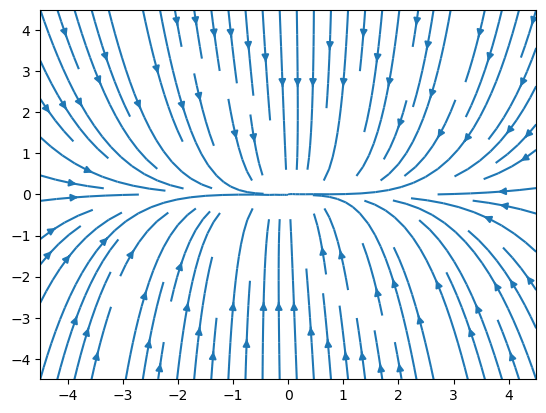

In [59]:
import matplotlib.pyplot as plt
x,y = np.meshgrid(np.linspace(-4.5, 4.5, 100), np.linspace(-4.5, 4.5, 100))
x_ = np.expand_dims(x, axis=2)
y_ = np.expand_dims(y, axis=2)
X_vec = np.concatenate([x_, y_],axis=2) 
linear_field = X_vec@A.T
print(x.shape)
fig, ax = plt.subplots()
ax.streamplot(x,y,linear_field[:,:,0], linear_field[:,:,1], density=1)
plt.show()

### Estimating vector field describing the field with radial basis functions

We now try to approximate the vector field using radial basis functions (with the number of centers between
100 and 1000), such that

$\frac{d}{ds}\psi(s, x(t)) \approx \hat{f}_{rbf}(x(t)) = \nu^{(k)} = C\phi(x(t))$

$\hat{f}_{rbf}(x(t)) = C\phi(x(t))$

Here we take $\Phi(X) C = F_{rbf}$

where $X \in R^{N X n}$ is the data array for the vector field, and $F_{rbf} \in R^{N X d}$ and $N$, $d$ are the number of points (vectors) and vector dimensions respectively.

Radial Basis Function matrix $\Phi(X) \in R^{N X L}$ equals 

$\Phi(X) = \exp(-||X - x_{l}||^{2}/\epsilon^{2})$

with coefficient matrix $C \in R^{L  X  d}$

where $L$ is the number of basis functions used and $x_{l}$ is the array containing the centers of the $L$ basis functions chosen. Here $n$ and $d$ are both equal to 2.

It makes sense to find the permutation of best L centers $x_{l}$ ($l=1,2,...L$) and $\epsilon$ which most accurately describes the vector field with minimal mean squared error.

In [60]:
F_rbf = F_linear
eps, L, C, xl = find_best_params_rbf(L_range=range(100, 1000, 2), eps_range=np.linspace(0.1, 5, 20), X0=X0, X1=X1, F_rbf=F_rbf,dt=dt, verbose=True)

Present Config L=100 MSE: 0.000785, Min MSE:0.000785, Min eps:1.389, Min L:100
Present Config L=102 MSE: 0.000804, Min MSE:0.000785, Min eps:1.389, Min L:100
Present Config L=104 MSE: 0.000810, Min MSE:0.000785, Min eps:1.389, Min L:100
Present Config L=106 MSE: 0.000807, Min MSE:0.000785, Min eps:1.389, Min L:100
Present Config L=108 MSE: 0.000807, Min MSE:0.000785, Min eps:1.389, Min L:100
Present Config L=110 MSE: 0.000793, Min MSE:0.000785, Min eps:1.389, Min L:100
Present Config L=112 MSE: 0.000808, Min MSE:0.000785, Min eps:1.389, Min L:100
Present Config L=114 MSE: 0.000811, Min MSE:0.000785, Min eps:1.389, Min L:100
Present Config L=116 MSE: 0.000794, Min MSE:0.000785, Min eps:1.389, Min L:100
Present Config L=118 MSE: 0.000799, Min MSE:0.000785, Min eps:1.389, Min L:100
Present Config L=120 MSE: 0.000823, Min MSE:0.000785, Min eps:1.389, Min L:100
Present Config L=122 MSE: 0.000834, Min MSE:0.000785, Min eps:1.389, Min L:100
Present Config L=124 MSE: 0.000821, Min MSE:0.000785

Since the MSE errors are much smaller when the vector field is approximated with non-linear radial basis functions. 

It is safe to conclude that the field is non-linear. 

Integrating the vector field over time for $t_{final} = 300 * dt$ we get the final state...

In [71]:
# def rbf_model2(t,z, eps, xl, C):
#     z = np.tile(np.expand_dims(z, axis=0), [len(xl),1]) 
#     phi_z = np.exp(-np.sum((z-xl)**2, axis=1)/(eps**2)).reshape(1,-1)
    
#     return (phi_z@C).reshape(-1)

time = np.linspace(0, dt*300, 1000)
sol_list2 = []
for i in range(len(X0)):
    sol = solve_ivp(rbf_model2, t_span=[0,dt*300], y0=X0[i,:].T,args=(eps, xl, C, ) ,t_eval=time)
    sol_list2.append(sol.y[:,-1])

In [62]:
sol_array = np.array(sol_list2)
print(sol_array.shape)

(2000, 2)


In [63]:
try_vec = np.array([1,2,3,4,5,6,7,8,9, 10, 11, 12])
try_vec = np.expand_dims(try_vec, axis=1)
try_vec = np.reshape(try_vec, (6,2), order='F')

print(try_vec)
try_vec = np.reshape(try_vec, (3,2,2), order='F')
print(try_vec)

[[ 1  7]
 [ 2  8]
 [ 3  9]
 [ 4 10]
 [ 5 11]
 [ 6 12]]
[[[ 1  7]
  [ 4 10]]

 [[ 2  8]
  [ 5 11]]

 [[ 3  9]
  [ 6 12]]]


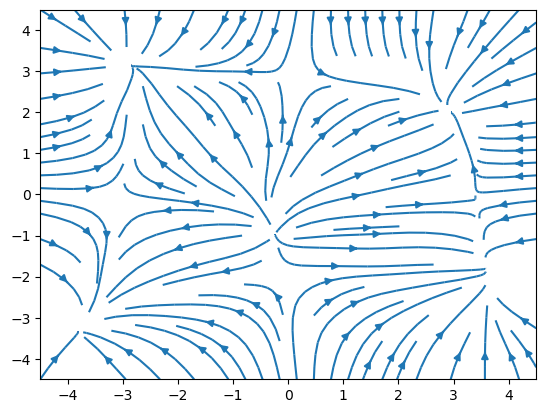

In [72]:
X_vec_ = X_vec.reshape(X_vec.shape[0]*X_vec.shape[1],-1)
Z = np.tile(X_vec_, [L,1])
X_l_ = np.repeat(xl, X_vec.shape[0]*X_vec.shape[1], axis=0)
Phi_z =  np.reshape(np.exp(-np.sum((Z-X_l_)**2, axis=1)/(eps**2)), (X_vec.shape[0] * X_vec.shape[1], -1), order='F')  
# print(Phi_z.shape)
# print(Z)
# print(X_l_)
non_linear_field = Phi_z@C
non_linear_field = np.reshape(non_linear_field, (X_vec.shape[0], X_vec.shape[1], 2), order='C')
#non_linear_field.reshape(X_vec.shape[0], X_vec.shape[1], 2)
fig1, ax1 = plt.subplots()
ax1.streamplot(x, y, non_linear_field[:,:,0], non_linear_field[:,:,1])
plt.show()

Printing it as a scatter plot

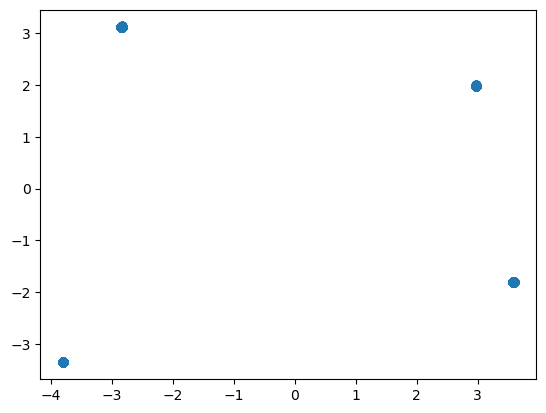

In [73]:
import matplotlib.pyplot as plt
import itertools
colors = itertools.cycle(["r", "b", "g"])

plt.scatter(sol_array[:,0], sol_array[:,1])

We can see that we have 4 stable states for any point in the field.

where our initial field X0 looked like ...

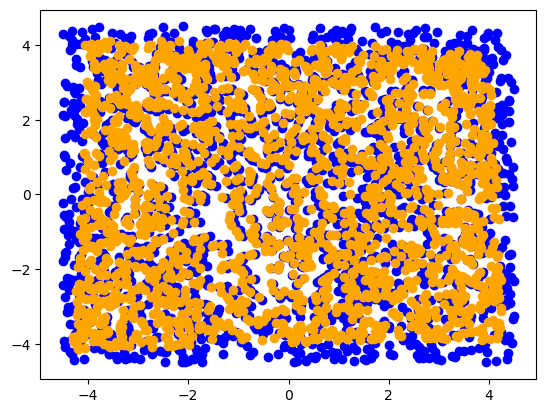

In [66]:
plt.scatter(X0[:,0], X0[:,1], color='blue')
plt.scatter(X1[:,0], X1[:,1], color='orange')
#print(sol.y.shape)
#plt.scatter(sol.y[:,0][0], sol.y[:,0][1], color='red')

Integrating linear field for the same amount of time, we get ...

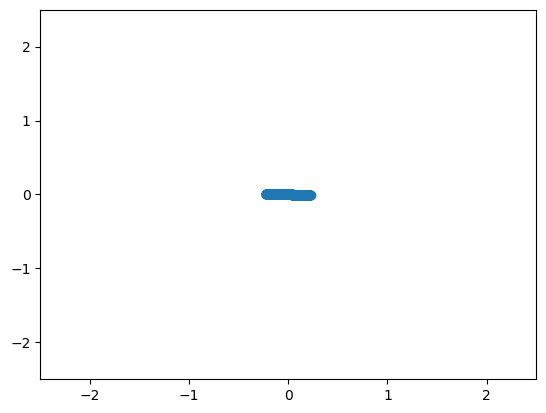

In [69]:
time = np.linspace(0, dt*300, 1000)
sol_list3 = []
for i in range(len(X0)):
    sol = solve_ivp(model, t_span=[0,dt*300], y0=X0[i,:].T, t_eval=time)
    sol_list3.append(sol.y[:,-1])

sol_array1 = np.array(sol_list3)
plt.xlim(-2.5, 2.5)
plt.ylim(-2.5, 2.5)
plt.scatter(sol_array1[:,0], sol_array1[:,1])
    

Since the stable states of the linear and non linear vector fields are very different, they are not topologically equivalent